# Requirements
```
scikit-learn == 0.24.1
numpy == 1.19.5
pandas == 1.1.0
```
# Data inspection
The dataset contains 250 samples and 6 categorical features each of which describes a type of internal risk. At this point, features could be assumed to be independent of each other.

No missing values, the class distribution is slightly skewed to the negative(NB) class.

In [381]:
import pandas as pd
import numpy as np

In [382]:
bankruptcy = pd.read_csv('./qualitative_banking/Qualitative_Bankruptcy.data.txt', header=None)
bankruptcy.columns = ['IR', 'MR', 'FF', 'CR', 'CO', 'OP', 'target']
bankruptcy.head(5)

,IR,MR,FF,CR,CO,OP,target
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


In [383]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Feature encoding
Each feature has 3 categories indicating negative, average and positive.

To preserve the order of the categories, The ordinal encoder is applied to encode the features.

The binary target is encoded by a label encoder.

In [384]:
lb_encoder = LabelEncoder()
or_encoder = OrdinalEncoder()
X = bankruptcy.drop('target', axis=1)
y = bankruptcy['target']
y = lb_encoder.fit_transform(y)
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.2, random_state=29)
dict(zip(lb_encoder.classes_, lb_encoder.transform(lb_encoder.classes_)))

{'B': 0, 'NB': 1}

In [385]:
X_train = or_encoder.fit_transform(X_train)
X_vali = or_encoder.fit_transform(X_vali)

# Modelling & Evaluation

## Model selection
As mentioned, we made the feature independent assumption. For better interpretability, a Naive Bayes classifier is selected.

The model is trained on 200 samples and is validated on the rest 50 samples.

## Evaluation
As mentioned, the dataset is slightly skewed. Thus, accuracy is used for evaluation. If data becomes more skewed in real world, recall, precision or F1 can be used instead. 

The confusion matrix shows there is 1 false positive.

Note: {'B': 0, 'NB': 1}

Accuracy 0.98


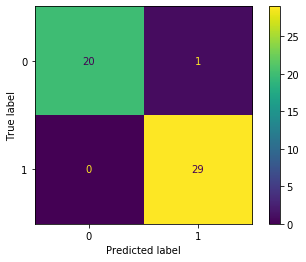

In [386]:
catnb = CategoricalNB()
catnb.fit(X_train, y_train)
preds = catnb.predict(X_vali)
print('Accuracy', accuracy_score(y_pred=preds, y_true=y_vali))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred=preds, y_true=y_vali), display_labels=catnb.classes_).plot()

#### Error analysis
The model predicts a bankrupted sample as not bankrupted.

In [387]:
preds_golds = pd.DataFrame({'pred': preds, 'gold': y_vali})
error_id = preds_golds[preds_golds['pred'] != preds_golds['gold']].index
print('Error data point', X_vali[error_id])
print('Decoded data', or_encoder.inverse_transform( X_vali[error_id]))
print('Predicted probability for 0 and 1 class given by Naive Bayes: ')
print(catnb.predict_proba(X_vali[error_id]))
preds_golds.iloc[error_id]

Error data point [[1. 0. 2. 0. 1. 2.]]
Decoded data [['N' 'A' 'P' 'A' 'N' 'P']]
Predicted probability for 0 and 1 class given by Naive Bayes: 
[[0.30026419 0.69973581]]


,pred,gold
6,1,0


#### Examining the estimated probability
The log probability is transformed back to empirical probability using exp.

The feature_log_prob_ is in shape (n features, classes, feature categories), from which we can calculate $P(y=1 | x=x_{error})$ for the error sample.

In this case, $x_{error} = [IR=N,MR=A,FF=P,CR=A,CO=N,OP=P]$

$P(y=1 | x=x_{error}) \propto \prod_{j} P_{x_{error}^j|y=1} P(y=1)$

We can see from the empirical probabilities where $P(CO=N | y=NB) = 0.0085$ and $P(CO=N | y=B) = 0.94$.

Although CO=N is a strong signal of bankruptcy, other indicators such as MR=A,FF=P,CR=A,OP=P show the opposite.

In [388]:
# catnb.class_count_, catnb.category_count_
# index mapping A:0 N:1 P:2, B:0, NB:1
np.exp(catnb.feature_log_prob_)

array([[[0.26966292, 0.48314607, 0.24719101],
        [0.33333333, 0.25641026, 0.41025641]],

       [[0.21348315, 0.6741573 , 0.11235955],
        [0.33333333, 0.31623932, 0.35042735]],

       [[0.04494382, 0.94382022, 0.01123596],
        [0.47008547, 0.12820513, 0.4017094 ]],

       [[0.16853933, 0.80898876, 0.02247191],
        [0.44444444, 0.06837607, 0.48717949]],

       [[0.04494382, 0.94382022, 0.01123596],
        [0.35042735, 0.00854701, 0.64102564]],

       [[0.24719101, 0.58426966, 0.16853933],
        [0.21367521, 0.36752137, 0.41880342]]])